# ppkt statistics

This notebook performs quality assessment and calculate descriptive statistics about a phenopacket-store release. 
The input file is the zip file that is or will be added to each release.

In [1]:
from ppktstore.stats import PPKtStoreStats

In [2]:
stats = PPKtStoreStats(input_zipfile="all_phenopackets.zip")

In [3]:
df = stats.get_df()
df.head()

,disease,disease_id,patient_id,gene,allele_1,allele_2,PMID
0,Neurodevelopmental disorder with intracranial ...,OMIM:620371,Individual KCHYD24-1,ESAM,NM_138961.3:c.605T>G,,PMID:36996813
1,Neurodevelopmental disorder with intracranial ...,OMIM:620371,Individual 1,ESAM,NM_138961.3:c.115del,,PMID:36996813
2,Neurodevelopmental disorder with intracranial ...,OMIM:620371,Individual 13,ESAM,NM_138961.3:c.451+1G>A,,PMID:36996813
3,Neurodevelopmental disorder with intracranial ...,OMIM:620371,Individual 7,ESAM,NM_138961.3:c.115del,,PMID:36996813
4,Neurodevelopmental disorder with intracranial ...,OMIM:620371,Individual 12,ESAM,NM_138961.3:c.451+1G>A,,PMID:36996813


In [4]:
stats_d = stats.get_descriptive_stats()
for k,v in stats_d.items():
    print(k,v)

phenopackets 4188
diseases 386
genes 343
alleles 2054
PMIDs 616
individuals per disease (max) 464
individuals per disease (min) 1
individuals per disease (mean) 10.849740932642487
individuals per disease (median) 1.0
individuals per disease (n>=10) 88
individuals per disease (n>=20) 45
individuals per disease (n>=50) 18
individuals per disease (n>=100) 6
genes associated with a single disease 321
genes associated with two diseases 13
genes associated with multiple diseases 22
gene with maximum number of diseases SCO2 with 7 associated diseases
individuals per gene (max) 464
individuals per gene (min) 1
individuals per gene (mean) 12.209912536443149
individuals per gene (median) 1.0
individuals per gene (n>=10) 69
individuals per gene (n>=20) 42
individuals per gene (n>=50) 20
individuals per gene (n>=100) 8


In [5]:
counts_per_disease = stats.get_counts_per_disease()

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [66]:
def plot_with_max(count_list, max_val, colors=None):
    teal_color = "#298c8c"
    purple_color = "#800074"
    if colors is None:
        colors = (teal_color, purple_color)
    truncated_list = [min(x, max_val) for x in count_list]
    ax = sns.histplot(truncated_list, bins=max_val, color=colors[0])
    counts, bins = np.histogram(truncated_list, bins=max_val)
    increment = 0.05 * np.max(counts) # distance from top of bar to text
    x = bins[-1]
    y = counts[-1] + increment
    ax.text(x, y, f"≥{max_val}",
       fontsize = 12,
       fontstyle = "normal",
       fontweight = "bold",
       color = colors[1],
       ha = "right", # Horizontal alignment
       va = "center") # Vertical alignment



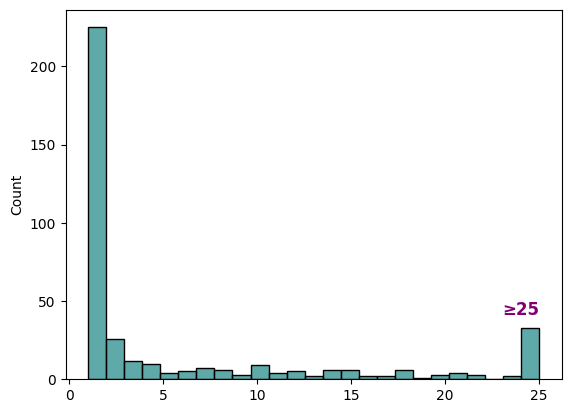

In [67]:
plot_with_max(count_list=counts_per_disease, max_val=25)